# Transpose Trajectory

Takes a real glider trajectory and moves it to a [region covered by LLC4320](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=).

## Getting started

I cloned [this repo](https://github.com/earthcube2021/ec21_balwada_etal) to my local machine, and copied the `data` folder over to my local copy of our project repo. I renamed it `glider_data`. I can push the folder at some point if we think that's best.

## Current status

This script will currently generate an xarray dataset containing the both the original and shifted lat, lon, in addition to pressure, temp, and salinity. Remaining issues/questions:
- What format does a trajectory need to be in to feed into interpolation?
    - How to match up lat, lons w/ llc4320 coords?
- The trajectory does extend outside the model region in parts. How to address this?
- The dataset still contains pressure rather than depth
- The transposed coordinates were added as coordinates rather than data variables, and I'm not sure why

## Warning

The maps generated below were sanity checks; they take a long time to plot and are not pretty.

In [23]:
## Imports

# Native packages
import os

# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Third-party packages for data visualizations
import geopandas as gpd
import matplotlib.pyplot as plt

## Load data

(Code copied from the [repo](https://github.com/earthcube2021/ec21_balwada_etal) notebook.)

In [5]:
# locate the data folder
data_folder = './glider_data'

In [6]:
# open glider files

ds_CTD_659 = xr.load_dataset(os.path.join(data_folder , 'sg659', 'CTD_659.nc'))
ds_CTD_660 = xr.load_dataset(os.path.join(data_folder , 'sg660', 'CTD_660.nc'))

ds_O2_659 = xr.load_dataset(os.path.join(data_folder , 'sg659', 'O2_659.nc'))
ds_O2_660 = xr.load_dataset(os.path.join(data_folder , 'sg660', 'O2_660.nc'))

ds_Chl_659 = xr.load_dataset(os.path.join(data_folder , 'sg659', 'Chl_659.nc'))
ds_Chl_660 = xr.load_dataset(os.path.join(data_folder , 'sg660', 'Chl_660.nc'))

These data files are stored as 1D arrays of measurements at each observation point, where the location (longitude, latitude, and depth) and time of measurement for the observation point are also part of the data set.

In [15]:
ds_CTD_659

<xarray.Dataset>
Dimensions:      (ctd_data_point: 1363330)
Dimensions without coordinates: ctd_data_point
Data variables:
    pressure     (ctd_data_point) float64 nan nan nan nan ... 1.165 1.037 nan
    latitude     (ctd_data_point) float64 -51.51 -51.51 -51.51 ... -51.7 -51.7
    longitude    (ctd_data_point) float64 30.03 30.03 30.03 ... 38.99 38.99
    temperature  (ctd_data_point) float64 3.564 3.561 3.56 ... 1.812 1.811 1.814
    salinity     (ctd_data_point) float64 nan nan nan nan ... 33.89 33.89 nan
    dives        (ctd_data_point) float64 1.0 1.0 1.0 1.0 ... 462.5 462.5 462.5
    time         (ctd_data_point) datetime64[ns] 2019-04-30T13:20:51.23000345...

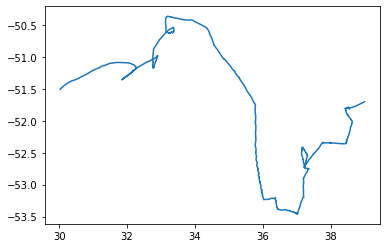

In [30]:
## Plot trajectory

plt.plot(ds_CTD_659.longitude.data, ds_CTD_659.latitude.data)
plt.show()

We want to transpose this dataset to the LLC4320 Southern Ocean region:

North Bounding Coordinate: -53.00567 degrees <br>
South Bounding Coordinate: -56.98995 degrees <br>
West Bounding Coordinate: 150.3021 degrees <br>
East Bounding Coordinate: 154.2812 degrees <br>

Ellipsoid: WGS 84

The current bounding box of the trajectory is:

North Bounding Coordinate: -50.363265 degrees <br>
South Bounding Coordinate: -53.458083 degrees <br>
West Bounding Coordinate: 30.026965 degrees <br>
East Bounding Coordinate: 38.99485 degrees <br>

In [72]:
## Plot current trajectory on world map (SLOW)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

df = pd.DataFrame({
        'lat':ds_CTD_659.latitude.data,
        'lon':ds_CTD_659.longitude.data
    })

original = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(df.lon, df.lat))

ax = world['geometry'].plot()
original['geometry'].plot(ax=ax, color="black")

In [42]:
## Transpose

# Lat
model_boundary_n = -53.00567
shifted_lat = ds_CTD_659.latitude.data - (max(ds_CTD_659.latitude.data) - model_boundary_n)

# Lon
model_boundary_w = 150.3021
shifted_lon = ds_CTD_659.longitude.data + (model_boundary_w - min(ds_CTD_659.longitude.data))

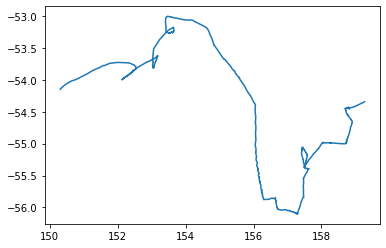

In [59]:
## Plot

plt.plot(shifted_lon, shifted_lat)
plt.show()

<AxesSubplot:>

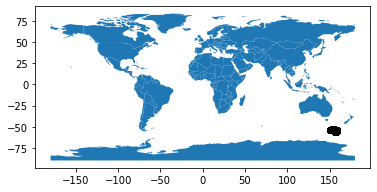

In [78]:
## Plot on world map (SLOW)

df = pd.DataFrame({
        'lat':shifted_lat,
        'lon':shifted_lon
    })

shifted = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(df.lon, df.lat))

ax = world['geometry'].plot()
shifted['geometry'].plot(ax=ax, color="black")

In [84]:
## Add shifted coordinates to original xr object

ds_CTD_659 = ds_CTD_659.assign(shifted_latitude = shifted_lat, shifted_longitude = shifted_lon)
ds_CTD_659

<xarray.Dataset>
Dimensions:            (ctd_data_point: 1363330, shifted_latitude: 1363330, shifted_longitude: 1363330)
Coordinates:
  * shifted_latitude   (shifted_latitude) float64 -54.15 -54.15 ... -54.34
  * shifted_longitude  (shifted_longitude) float64 150.3 150.3 ... 159.3 159.3
Dimensions without coordinates: ctd_data_point
Data variables:
    pressure           (ctd_data_point) float64 nan nan nan ... 1.165 1.037 nan
    latitude           (ctd_data_point) float64 -51.51 -51.51 ... -51.7 -51.7
    longitude          (ctd_data_point) float64 30.03 30.03 ... 38.99 38.99
    temperature        (ctd_data_point) float64 3.564 3.561 3.56 ... 1.811 1.814
    salinity           (ctd_data_point) float64 nan nan nan ... 33.89 33.89 nan
    dives              (ctd_data_point) float64 1.0 1.0 1.0 ... 462.5 462.5
    time               (ctd_data_point) datetime64[ns] 2019-04-30T13:20:51.23...

**I'm not sure why that added coordinates rather than data variables...**

In [85]:
## Look at model data

dd = xr.open_dataset('LLC4320_pre-SWOT_ACC_SMST_20111221.nc')

In [86]:
dd

<xarray.Dataset>
Dimensions:   (j_g: 349, i: 192, i_g: 192, j: 349, k: 84, k_u: 84, k_l: 84, k_p1: 85, nb: 2, time: 24)
Coordinates:
  * j_g       (j_g) float32 0.0 1.0 2.0 3.0 4.0 ... 345.0 346.0 347.0 348.0
  * i         (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
  * i_g       (i_g) float32 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j         (j) float32 0.0 1.0 2.0 3.0 4.0 ... 344.0 345.0 346.0 347.0 348.0
  * k         (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 74 75 76 77 78 79 80 81 82 83
  * k_u       (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_l       (k_l) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_p1      (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 75 76 77 78 79 80 81 82 83 84
  * nb        (nb) int32 0 1
  * time      (time) datetime64[ns] 2011-12-21 ... 2011-12-21T23:00:00
Data variables: (12/35)
    XC        (j, i) float32 ...
    YC        (j, i) float32 ...
    DXV       (j, i) float32 ...
    DYU       (j, i) float32 ...
    Depth     (j, i) float32 ...
    AngleSN   (j, i) float32 ...
    ...        ...
    oceTAUY   (time, j_g, i) float64 ...
    Theta     (time, k, j, i) float64 ...
    Salt      (time, k, j, i) float64 ...
    U         (time, k, j, i_g) float32 ...
    V         (time, k, j_g, i) float64 ...
    W         (time, k_l, j, i) float64 ...
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2011-12-21 23:00:00
    time_coverage_start:             2011-12-21 00:00:00
    title:                           LLC4320 regional Southern Ocean
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm